# About

This notebook analyses the proteinGroup_tryptic.csv without applying log2 fold-change on the intensities. First we do relevant imports and define functions to for wrangling the data.

In [1]:
import os 
import pandas as pd
import numpy as np

from get_columns import get_cell_line_state_replicate, get_base_cols_proteinGroups, get_all_peptide_counts, get_razor_and_unique_peptide_counts, get_unique_peptides, get_sequence_coverage, get_all_reporter_intensity_correct, get_reporter_intensity_without_control
from column_mapper import col_to_treatment_mapper, treatment_nomenclature_map_dict, col_to_cell_line_mapper, col_to_state_mapper, col_to_rep_mapper


In [2]:
os.chdir("/home/ptruong/git/lifeAndDeath/data/amirata")
df = pd.read_csv("proteinGroups tryptic.csv", sep = "\t")

/home/ptruong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (726,727) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:

cell_lines, states, replicates = get_cell_line_state_replicate()

base_cols = get_base_cols_proteinGroups()
peptide_count_cols = get_all_peptide_counts()
#razor_and_unique_peptides_cols = get_razor_and_unique_peptide_counts()
#unique_peptides_cols = get_unique_peptides()
sequence_coverage_cols = get_sequence_coverage()
reporter_intensity_corrected_cols = get_all_reporter_intensity_correct()

In [4]:

def select_rep_state_intensities(rep, state):
    intensity_list = []
    for i in reporter_intensity_corrected_cols:
        if i.split(" ")[4].split("_")[2] == ("Rep" + str(rep)):
            if i.split(" ")[4].split("_")[1] == state:
                intensity_list.append(i)
    return intensity_list

def select_rep_state_cell_line_intensities(rep, state, cell_line):
    intensity_list = []
    for i in reporter_intensity_corrected_cols:
        if i.split(" ")[4].split("_")[2] == ("Rep" + str(rep)):
            if i.split(" ")[4].split("_")[1] == state:
                if i.split(" ")[4].split("_")[0] == cell_line:
                    intensity_list.append(i)
    return intensity_list


## Tresholding based on peptide count and sequence coverage

We then make dataframes and define functions so we can treshold the data based on peptide count and sequence coverage.

In [5]:

df_base = df[get_base_cols_proteinGroups()]
df_peptide_count = df[peptide_count_cols]
df_sequence_coverage = df[sequence_coverage_cols]

In [6]:

def apply_peptide_count_treshold(df_subset, treshold = 1):
    for i in df_subset.columns:
        col = "Peptides " + i.split(" ")[-1]
        peptide_count = df_peptide_count[col]
        peptide_count_treshold_boolean_array = (peptide_count > treshold)
        df_subset[i] = df_subset[i] * peptide_count_treshold_boolean_array
    return df_subset

def apply_sequence_coverage_treshold(df_subset, treshold = 0):
    for i in df_subset.columns:
        col = "Sequence coverage " + i.split(" ")[-1] + " [%]"
        sequence_coverage = df_sequence_coverage[col]
        sequence_coverage_treshold_boolean_array = (sequence_coverage > treshold)
        df_subset[i] = df_subset[i] * sequence_coverage_treshold_boolean_array
    return df_subset

def apply_treshold(df_subset, peptide_count_treshold = 1, sequence_coverage_percentage_treshold = 0):
    df_subset = apply_peptide_count_treshold(df_subset, peptide_count_treshold)
    df_subset = apply_sequence_coverage_treshold(df_subset, sequence_coverage_percentage_treshold)
    return df_subset

def subtract_df_with_col(df, col):
    """
    test to see results:
    a = pd.DataFrame(np.array([[1,1,1],[2,4,8],[3,6,9]]).T, columns = ["a", "b", "c"])
    (a.T - a.a).T
    subtract_df_with_col(a, "a")
    """
    return (df.T - df[col]).T

def compute_control_to_treated_fc(df_subset):
    control_col = df_subset.columns[0]
    fc = subtract_df_with_col(df_subset, control_col)
    return fc


def get_df_with_control_vs_treated_fc(df_t):
    """
    df_t is tresholded and logged df with all reporter_intensity_corrected_cols
    """
    df_fc = pd.DataFrame()
    for cell_line in cell_lines:
        for state in states:
            for replicate in replicates:
                df_subset = df_t[select_rep_state_cell_line_intensities(replicate, state, cell_line)]            
                fc = compute_control_to_treated_fc(df_subset)
                if df_fc.empty:
                    df_fc = df_fc.append(fc)
                else:
                    df_fc = df_fc.join(fc)
    return df_fc


## Tresholding parameters

We define peptide count and sequence coverage (%) treshold and perform the filtering below. We also remove the control samples from the data to be analyzed using scikit.

In [7]:

peptide_count_treshold = 1
sequence_coverage_percentage_treshold = 0

df_t = apply_treshold(df[reporter_intensity_corrected_cols], peptide_count_treshold, sequence_coverage_percentage_treshold)
df_t = df_t.replace({0:np.nan})
df_t = np.log2(df_t)
df_res = df_base.join(df_t)

# Q-value treshold
df_res = df_res[df_res["Q-value"] < 0.05] # We needed to do this step to treshold for q-values. perhaps could have done earlier?

# This is the data matrix we work with.
df_int = df_res[get_reporter_intensity_without_control()]
df_int = df_int.T
df_int_proteins = df_int.columns

<ipython-input-6-b3cb488bddd5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[i] = df_subset[i] * peptide_count_treshold_boolean_array
<ipython-input-6-b3cb488bddd5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[i] = df_subset[i] * peptide_count_treshold_boolean_array
<ipython-input-6-b3cb488bddd5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

<ipython-input-6-b3cb488bddd5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[i] = df_subset[i] * sequence_coverage_treshold_boolean_array
<ipython-input-6-b3cb488bddd5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[i] = df_subset[i] * sequence_coverage_treshold_boolean_array
<ipython-input-6-b3cb488bddd5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

# Defining targets

We create mapper function so that we can use different targets for our analysis.

In [9]:

# Map columns so we can plot 
df_int["treatment_num"] = df_int.index.map(col_to_treatment_mapper)
df_int["treatment_name"] = df_int.treatment_num.map(treatment_nomenclature_map_dict)
df_int["cell_line"] = df_int.index.map(col_to_cell_line_mapper)
df_int["state"] = df_int.index.map(col_to_state_mapper)
df_int["rep"] = df_int.index.map(col_to_rep_mapper)

## PCA



In [10]:

#######
# PCA #
#######

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [18]:

def pca_on_cell_line(df_int, cell_line):
    # splice df_int for pca now
    df_pca = df_int[df_int.cell_line == cell_line]
    
    features = df_int_proteins
    
    # Separating out the features
    x = df_pca.loc[:, features].values
    
    # Separating out the target
    classification = "state" # Choose target - treatment, cell_line, state here
    y = df_pca.loc[:,[classification]].values
    
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    
    # Missing value impuration
    imputer = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value = 0)
    x = imputer.fit_transform(x)
    
    # pca
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, df_pca[[classification]].reset_index()[classification]], axis = 1)
    
    #Visualization
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = finalDf[classification].unique()
    colors = ['r', 'g', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf[classification] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.set_title(cell_line)
    ax.grid()

/home/ptruong/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/ptruong/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


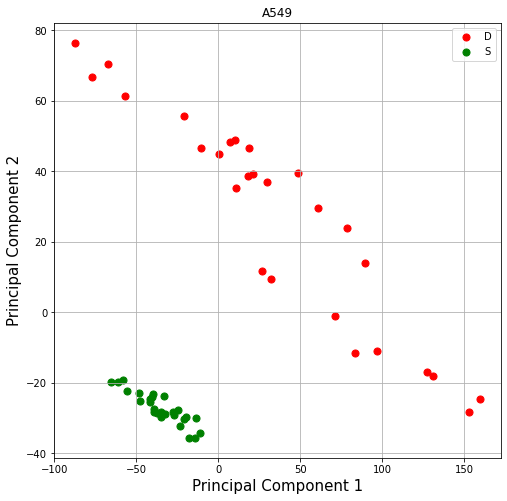

In [19]:
pca_on_cell_line(df_int, "A549")

/home/ptruong/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/ptruong/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


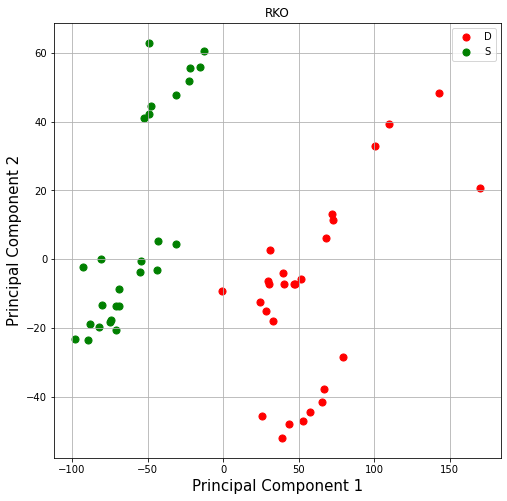

In [20]:
pca_on_cell_line(df_int, "RKO")

/home/ptruong/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/ptruong/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


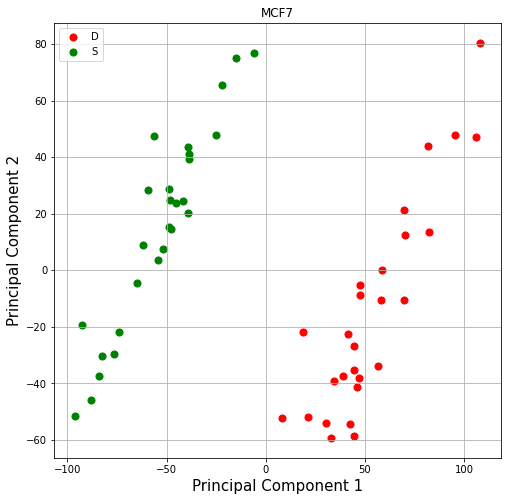

In [21]:
pca_on_cell_line(df_int, "MCF7")

In [22]:

def pca_on_state(df_int, state):
    # splice df_int for pca now
    df_pca = df_int[df_int.state == state]
    
    features = df_int_proteins
    
    # Separating out the features
    x = df_pca.loc[:, features].values
    
    # Separating out the target
    classification = "cell_line" # Choose target - treatment, cell_line, state here
    y = df_pca.loc[:,[classification]].values
    
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    
    # Missing value impuration
    imputer = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value = 0)
    x = imputer.fit_transform(x)
    
    # pca
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, df_pca[[classification]].reset_index()[classification]], axis = 1)
    
    #Visualization
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = finalDf[classification].unique()
    colors = ['r', 'g', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf[classification] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.set_title(state)
    ax.grid()

/home/ptruong/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/ptruong/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


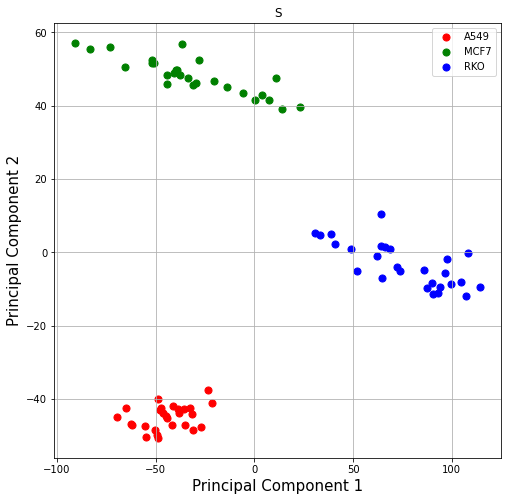

In [23]:
pca_on_state(df_int, "S")

/home/ptruong/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/ptruong/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


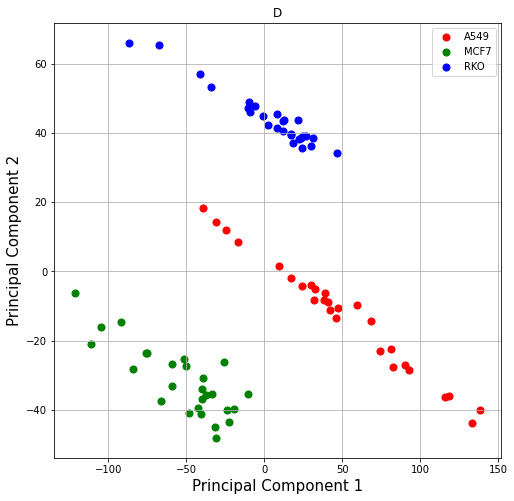

In [24]:
pca_on_state(df_int, "D")